In [1]:
# import matplotlib.pyplot as plt
from local_db import LocalDB
from datetime import datetime
import sqlite3
from local_db import LocalDB
# import matplotlib.pyplot as plt
import calendar
import csv

In [7]:
def heart_rate_data():
    heart_rate_list = []
    
    try:
        with open(r'F:\arduino.csv', newline='') as csvfile:
            reader = csv.DictReader(csvfile)
        
            for row in reader:
                heart_rate = int(row['heart_rate'])
                epoch_time = row['epoch_time']
                heart_rate_list.append((epoch_time, heart_rate))
                
    except FileNotFoundError:
        print("File not found!")
    except Exception as e:
        print("Error:", e)
    
    return heart_rate_list

heart_rate_data_list = heart_rate_data()

print(heart_rate_data_list)

[('1712447990', 0), ('1712447995', 0), ('1712448000', 0), ('1712448005', 0), ('1712448010', 0), ('1712448015', 0), ('1712448021', 0), ('1712448026', 0), ('1712448031', 0), ('1712448036', 0), ('1712448041', 0), ('1712448046', 0), ('1712448051', 91), ('1712448056', 94), ('1712448062', 89), ('1712448067', 91), ('1712448072', 95), ('1712448077', 84), ('1712448082', 95), ('1712448087', 82), ('1712448092', 80)]


In [ ]:
def step_count_data(self):
    step_count_list = []
    try:
        with open(r'F:\arduino.csv', newline='') as csvfile:
            reader = csv.DictReader(csvfile)
        
            for row in reader:
                step_count = int(row['step_count'])
                epoch_time = row['epoch_time']
                step_goal_percent = row['step_goal_percent']
                step_count_list.append((epoch_time, step_count, step_goal_percent))
                
    except FileNotFoundError:
        print("File not found!")
    except Exception as e:
        print("Error:", e)
    
    return step_count_list

heart_rate_data_list = step_count_data()

print(heart_rate_data_list)

In [32]:
class WaterIntake():
    def __init__(self, connection):
        self.connection = connection
        self.cursor = connection.cursor()

    def insert_water_intake(self, water_intake):
        try:
            with self.connection:
                columns = ', '.join(water_intake.keys())
                values = [water_intake.get(key, '') for key in water_intake.keys()]
                placeholders = ', '.join('?' for _ in water_intake.values())

                sql = f"""
                    INSERT INTO water_intake 
                    ({columns}) 
                    VALUES ({placeholders})
                """
                self.cursor.execute(sql, values)

        except sqlite3.IntegrityError as e:
            if "FOREIGN KEY constraint failed" in str(e):
                print("Error: Invalid workout_id or water_intake_id.")
            else:
                print(f"IntegrityError: {e}")

        except Exception as e:
            print(f"Error inserting water intake log: {e}")

    def get_water_intake_by_id(self, water_intake_id):
        with self.connection:
            self.cursor.execute("SELECT * FROM water_intake WHERE water_intake_id=?", (water_intake_id,))
            return self.cursor.fetchall()

    def get_water_intake_by_date(self, date_recorded):
        with self.connection:
            self.cursor.execute("SELECT * FROM water_intake WHERE date_recorded=?", (date_recorded,))
            return self.cursor.fetchall()

    def update_water_intake(self, water_intake_id, updated_values):
        table_name = 'water_intake'
        set_clause = ', '.join(f"{key} = :{key}" for key in updated_values.keys())
        sql = f"UPDATE {table_name} SET {set_clause} WHERE water_intake_id = :water_intake_id"
        updated_values['water_intake_id'] = water_intake_id

        with self.connection:
            self.cursor.execute(sql, updated_values)
    
    def get_all_water_intake(self):
        water_intakes = []
        sql = "SELECT * FROM water_intake"
        self.cursor.execute(sql)
        rows = self.cursor.fetchall()
        for row in rows:
            water_intakes.append(row)
        return water_intakes

    def remove_water_intake(self, water_intake_id):
        with self.connection:
            self.cursor.execute("DELETE FROM water_intake WHERE water_intake_id=?", (water_intake_id,))

    def drop_water_intake(self):
        with self.connection:
            self.cursor.execute("DROP TABLE IF EXISTS water_intake")

    def verify_water_intake(self, water_intake, date_recorded):
        # Convert water_intake to string before checking its length
        water_intake_str = str(water_intake)

        if len(water_intake_str) > 5:
            return 11  # Error code for water intake length exceeds limit

        try:
            water_intake = int(water_intake)
        except ValueError:
            return 12  # Error code for invalid water intake format (non-integer)

        if water_intake <= 0:
            return 13  # Error code for no water intake provided

        if not date_recorded:
            return 14  # Error code for no date selected

        # Add current time
        time_recorded = datetime.now().strftime('%H:%M:%S')

        existing_records = self.get_water_intake_by_date(date_recorded)
        if existing_records:
            # Access the first element of the tuple
            water_intake_id = existing_records[0][0]
            updated_values = {'water_intake_ml': water_intake, 'time_recorded': time_recorded}
            self.update_water_intake(water_intake_id, updated_values)
        else:
            new_water_intake = {'water_intake_ml': water_intake, 'date_recorded': date_recorded, 'time_recorded': time_recorded}
            self.insert_water_intake(new_water_intake)

        return 15  # Success code

    def monthly_water_intake_graph(self, selected_month, selected_year):
        days_in_month = 31
        if selected_month in [4, 6, 9, 11]:
            days_in_month = 30
        elif selected_month == 2:
            days_in_month = 29 if (selected_year % 4 == 0 and selected_year % 100 != 0) or (selected_year % 400 == 0) else 28

        days_of_month = list(range(1, days_in_month + 1))
        sql = "SELECT water_intake_ml, date_recorded FROM water_intake WHERE SUBSTR(date_recorded, 4, 2) = ? AND SUBSTR(date_recorded, 7, 4) = ?"
        self.cursor.execute(sql, (str(selected_month).zfill(2), str(selected_year)))
        water_intake_data = self.cursor.fetchall()

        dates = []
        water_intakes = []

        for data in water_intake_data:
            day = int(data[1].split('/')[0])
            water_intake_ml = data[0]
            dates.append(day)
            water_intakes.append(water_intake_ml)

        plt.figure(figsize=(12, 8))
        plt.bar(dates, water_intakes, color='b', alpha=0.7)
        plt.xlabel('Day of the Month')
        plt.ylabel('Water Intake (ml)')
        plt.title(f'Monthly Water Intake for {selected_month}/{selected_year}')
        plt.xticks(days_of_month)
        plt.grid(axis='y')
        plt.axhline(y=2000, color='r', linestyle='--')
        plt.show()

    def yearly_water_intake_graph(self, selected_year):
        sql = "SELECT water_intake_ml, date_recorded FROM water_intake WHERE SUBSTR(date_recorded, 7, 4) = ?"
        self.cursor.execute(sql, (str(selected_year),))
        water_intake_data = self.cursor.fetchall()

        monthly_totals = {month: 0 for month in range(1, 13)}
        monthly_counts = {month: 0 for month in range(1, 13)}

        for data in water_intake_data:
            month = int(data[1].split('/')[1])
            water_intake_ml = data[0]
            monthly_totals[month] += water_intake_ml
            monthly_counts[month] += 1

        monthly_averages = {month: monthly_totals[month] / monthly_counts[month] if monthly_counts[month] != 0 else 0 for month in range(1, 13)}
        plt.figure(figsize=(12, 8))
        plt.bar(monthly_averages.keys(), monthly_averages.values(), color='b', alpha=0.7)
        plt.xlabel('Month')
        plt.ylabel('Average Water Intake (ml)')
        plt.title(f'Yearly Average Water Intake for {selected_year}')
        plt.xticks(range(1, 13))
        plt.grid(axis='y')
        plt.axhline(y=2000, color='r', linestyle='--')
        plt.show()

In [33]:
db = LocalDB('local_db.db')
# water_intake = WaterIntake(db.connection)


LocalDB Connection Established!



In [34]:
# db.print_water_intake()

In [35]:
# water_intake.monthly_water_intake_graph(1, 2024)

In [36]:
# water_intake.yearly_water_intake_graph(2023)

In [37]:
class Weight():
    def __init__(self, connection):
        self.connection = connection
        self.cursor = connection.cursor()

    def insert_weight(self, weight):
        try:
            with self.connection:
                columns = ', '.join(weight.keys())
                values = [weight.get(key, '') for key in weight.keys()]
                placeholders = ', '.join('?' for _ in weight.values())

                sql = f"""
                    INSERT INTO weight 
                    ({columns}) 
                    VALUES ({placeholders})
                """
                self.cursor.execute(sql, values)

        except sqlite3.IntegrityError as e:
            if "FOREIGN KEY constraint failed" in str(e):
                print("Error: Invalid workout_id or weight_id.")
            else:
                print(f"IntegrityError: {e}")

        except Exception as e:
            print(f"Error inserting workout log: {e}")

    def get_weight_by_id(self, weight_id):
        with self.connection:
            self.cursor.execute("SELECT * FROM weight WHERE weight_id=?", (weight_id,))
            return self.cursor.fetchall()

    def update_weight(self, weight_id, updated_values):
        table_name = 'weight'
        set_clause = ', '.join(f"{key} = :{key}" for key in updated_values.keys())
        sql = f"UPDATE {table_name} SET {set_clause} WHERE weight_id = :weight_id"
        updated_values['weight_id'] = weight_id

        with self.connection:
            self.cursor.execute(sql, updated_values)

    def remove_weight(self, weight_id):
        with self.connection:
            self.cursor.execute("DELETE FROM weight WHERE weight_id=?", (weight_id,))

    def drop_weight(self):
        with self.connection:
            self.cursor.execute("DROP TABLE IF EXISTS weight")

    def monthly_weight_data(self, selected_month, selected_year):
        days_in_month = calendar.monthrange(selected_year, selected_month)[1]
        days_of_month = list(range(1, days_in_month + 1))
        
        sql = "SELECT weight_kg, date_recorded FROM weight WHERE SUBSTR(date_recorded, 4, 2) = ? AND SUBSTR(date_recorded, 7, 4) = ?"
        self.cursor.execute(sql, (str(selected_month).zfill(2), str(selected_year)))
        weight_data = self.cursor.fetchall()

        dates = []
        weights = []

        for data in weight_data:
            day = int(data[1].split('/')[0])
            weight_kg = data[0]
            dates.append(day)
            weights.append(weight_kg)

        # plt.figure(figsize=(12, 6))
        plt.plot(dates, weights, color='brown', alpha=0.7)  # Set the color to brown
        plt.xlabel('Day of the Month')
        plt.ylabel('Weight (kg)')
        plt.title(f'Monthly Weight for {selected_month}/{selected_year}')
        plt.xticks(days_of_month)
        plt.grid(axis='y')
        plt.axhline(y=75, color='r', linestyle='--')
        plt.show()

        return [dates, weights, days_of_month]

    def yearly_weight_data(self, selected_year):
        sql = "SELECT weight_kg, date_recorded FROM weight WHERE SUBSTR(date_recorded, 7, 4) = ?"
        self.cursor.execute(sql, (str(selected_year),))
        weight_data = self.cursor.fetchall()

        monthly_totals = {month: 0 for month in range(1, 13)}
        monthly_counts = {month: 0 for month in range(1, 13)}

        for data in weight_data:
            month = int(data[1].split('/')[1])
            weight_kg = data[0]
            monthly_totals[month] += weight_kg
            monthly_counts[month] += 1

        monthly_averages = {month: monthly_totals[month] / monthly_counts[month] if monthly_counts[month] != 0 else 0 for month in range(1, 13)}
        months = list(monthly_averages.keys())
        averages = list(monthly_averages.values())

        plt.figure(figsize=(12, 8))
        plt.bar(months, averages, color='brown')
        plt.axhline(y=75, color='r', linestyle='--')
        plt.xlabel('Month')
        plt.ylabel('Average Weight (kg)')
        plt.title(f'Yearly Average Weight for {selected_year}')
        plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
        plt.grid(axis='y')
        plt.show()

        return [months, averages]

db = LocalDB('local_db.db')
weight = Weight(db.connection)

db.print_weight()
# db.close_connection()



LocalDB Connection Established!

(1, 70.0, '01/10/2023', '09:00:00')
(2, 69.0, '02/10/2023', '10:00:00')
(3, 68.0, '03/10/2023', '11:00:00')
(4, 67.0, '04/10/2023', '12:00:00')
(5, 68.0, '05/10/2023', '13:00:00')
(6, 68.7, '06/10/2023', '14:00:00')
(7, 69.2, '07/10/2023', '15:00:00')
(8, 70.0, '08/10/2023', '16:00:00')
(9, 71.0, '09/10/2023', '17:00:00')
(10, 72.5, '10/10/2023', '18:00:00')
(11, 73.0, '11/10/2023', '19:00:00')
(12, 68.0, '04/02/2024', '23:56:12')
(15, 75.0, '06/02/2024', '23:56:44')
(16, 73.0, '07/02/2024', '01:09:21')
(17, 69.1, '01/01/2024', '01:10:40')
(18, 68.2, '03/01/2024', '01:11:01')
(19, 67.9, '04/01/2024', '01:11:14')
(20, 68.5, '05/01/2024', '01:11:30')
(21, 67.9, '15/01/2024', '01:11:45')
(22, 67.7, '17/01/2024', '01:11:56')
(23, 68.3, '18/01/2024', '01:12:14')
(24, 67.4, '25/01/2024', '01:12:42')
(25, 68.0, '28/01/2024', '01:12:59')
(26, 67.5, '29/01/2024', '01:13:10')
(27, 67.4, '30/01/2024', '01:13:26')
(28, 78.0, '22/02/2024', '01:31:32')
(29, 77.5, '1

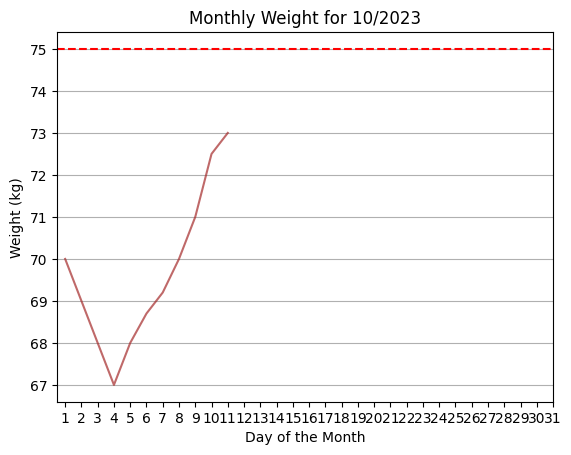

[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [70.0, 69.0, 68.0, 67.0, 68.0, 68.7, 69.2, 70.0, 71.0, 72.5, 73.0],
 [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31]]

In [38]:
weight.monthly_weight_data(10, 2023)

In [39]:
# weight.yearly_weight_data(2023)

In [40]:
class BodyFat():
    def __init__(self, connection):
        self.connection = connection
        self.cursor = connection.cursor()

    def insert_body_fat(self, body_fat, selected_date):
        try:
            current_time = datetime.now().strftime('%H:%M:%S')

            with self.connection:
                self.cursor.execute("SELECT * FROM body_fat WHERE date_recorded = ?", (selected_date,))
                existing_body_fat = self.cursor.fetchone()

                if existing_body_fat:
                    sql = """
                        UPDATE body_fat 
                        SET body_fat_kg = ?, time_recorded = ?
                        WHERE date_recorded = ?
                    """
                    self.cursor.execute(sql, (body_fat, current_time, selected_date))
                else:
                    sql = """
                        INSERT INTO body_fat (body_fat_kg, date_recorded, time_recorded)
                        VALUES (?, ?, ?)
                    """
                    self.cursor.execute(sql, (body_fat, selected_date, current_time))

        except sqlite3.IntegrityError as e:
            if "FOREIGN KEY constraint failed" in str(e):
                print("Error: Invalid workout_id or body_fat_id.")
            else:
                print(f"IntegrityError: {e}")

        except Exception as e:
            print(f"Error inserting body_fat data: {e}")

    def get_body_fat_by_id(self, body_fat_id):
        with self.connection:
            self.cursor.execute("SELECT * FROM body_fat WHERE body_fat_id=?", (body_fat_id,))
            return self.cursor.fetchall()

    def update_body_fat(self, body_fat_id, updated_values):
        table_name = 'body_fat'
        set_clause = ', '.join(f"{key} = :{key}" for key in updated_values.keys())
        sql = f"UPDATE {table_name} SET {set_clause} WHERE body_fat_id = :body_fat_id"
        updated_values['body_fat_id'] = body_fat_id

        with self.connection:
            self.cursor.execute(sql, updated_values)

    def remove_body_fat(self, body_fat_id):
        with self.connection:
            self.cursor.execute("DELETE FROM body_fat WHERE body_fat_id=?", (body_fat_id,))

    def drop_body_fat(self):
        with self.connection:
            self.cursor.execute("DROP TABLE IF EXISTS body_fat")

    def verify_body_fat(self, body_fat):
        if not body_fat:
            return 30  # empty body_fat
        try:
            # Convert body_fat data from string to float
            body_fat_float = float(body_fat)
            return 28  # valid body_fat
        except ValueError:
            return 29  # invalid skeletal muscle format


# body_fat = BodyFat(db.connection)

# BodyFat.insert_body_fat(90, '20/02/2024')

# print(db.print_body_fat())

In [41]:
class BMI():
    def __init__(self, connection):
        self.connection = connection
        self.cursor = connection.cursor()

    def calculate_bmi(self, weight, height):
        return round(weight / ((height/100) * (height/100)), 1)

    def insert_bmi(self, weight, height, selected_date):
        try:
            bmi = self.calculate_bmi(weight, height)
            current_time = datetime.now().strftime('%H:%M:%S')

            with self.connection:
                self.cursor.execute("SELECT bmi_id FROM bmi WHERE date_recorded=?", (selected_date,))
                existing_bmi_id = self.cursor.fetchone()

                if existing_bmi_id:
                    sql_update = """
                        UPDATE bmi 
                        SET bmi = ?, time_recorded = ?
                        WHERE bmi_id = ?
                    """
                    self.cursor.execute(sql_update, (bmi, current_time, existing_bmi_id[0]))
                else:
                    sql_insert = """
                        INSERT INTO bmi (bmi, date_recorded, time_recorded)
                        VALUES (?, ?, ?)
                    """
                    self.cursor.execute(sql_insert, (bmi, selected_date, current_time))

        except Exception as e:
            print(f"Error inserting BMI data: {e}")

    def get_bmi_by_id(self, bmi_id):
        with self.connection:
            self.cursor.execute("SELECT * FROM bmi WHERE bmi_id=?", (bmi_id,))
            return self.cursor.fetchall()

    def update_bmi(self, bmi_id, updated_values):
        table_name = 'bmi'
        set_clause = ', '.join(f"{key} = :{key}" for key in updated_values.keys())
        sql = f"UPDATE {table_name} SET {set_clause} WHERE bmi_id = :bmi_id"
        updated_values['bmi_id'] = bmi_id

        with self.connection:
            self.cursor.execute(sql, updated_values)

    def remove_bmi(self, bmi_id):
        with self.connection:
            self.cursor.execute("DELETE FROM bmi WHERE bmi_id=?", (bmi_id,))

    def drop_bmi(self):
        with self.connection:
            self.cursor.execute("DROP TABLE IF EXISTS bmi")

    def monthly_bmi_data(self, selected_month, selected_year):
        days_in_month = calendar.monthrange(selected_year, selected_month)[1]
        days_of_month = list(range(1, days_in_month + 1))

        sql = "SELECT bmi, date_recorded FROM bmi WHERE SUBSTR(date_recorded, 4, 2) = ? AND SUBSTR(date_recorded, 7, 4) = ?"
        self.cursor.execute(sql, (str(selected_month).zfill(2), str(selected_year)))
        bmi_data = self.cursor.fetchall()

        dates = []
        bmis = []

        for data in bmi_data:
            day = int(data[1].split('/')[0])
            bmi = data[0]
            dates.append(day)
            bmis.append(bmi)

        # Define BMI ranges and corresponding colors
        bmi_ranges = [18.5, 24.9, 29.9, 39.9, 52]
        colors = ['blue', 'lightblue', 'yellow', 'red', 'darkred']
        labels = ['Underweight', 'Healthy', 'Overweight', 'Obese', 'Morbidly Obese']

        plt.figure(figsize=(12, 6))
        for i in range(len(bmi_ranges)):
            plt.axhspan(bmi_ranges[i-1] if i > 0 else 0, bmi_ranges[i], color=colors[i], alpha=0.5)

        plt.plot(dates, bmis, color='brown', alpha=0.7)
        plt.title(f'Monthly BMI for {selected_month}/{selected_year}')
        plt.xlabel('Day of the Month')
        plt.ylabel('BMI')
        plt.xticks(days_of_month)
        plt.grid(axis='y')

        tick_labels = [f'{label} {value}' for label, value in zip(labels, bmi_ranges)]
        plt.yticks(bmi_ranges, tick_labels)
        plt.show()

    def yearly_bmi_data(self, selected_year):
        months = list(range(1, 13))  # Months of the year
        avg_bmi_values = []  # Average BMI values for each month

        # Define BMI ranges and corresponding colors
        bmi_ranges = [18.5, 24.9, 29.9, 39.9, 52]
        colors = ['blue', 'lightblue', 'yellow', 'red', 'darkred']
        labels = ['Underweight', 'Healthy', 'Overweight', 'Obese', 'Morbidly Obese']

        plt.figure(figsize=(12, 6))
        for i in range(len(bmi_ranges)):
            plt.axhspan(bmi_ranges[i-1] if i > 0 else 0, bmi_ranges[i], color=colors[i], alpha=0.5)

        for month in months:
            sql = "SELECT bmi FROM bmi WHERE SUBSTR(date_recorded, 4, 2) = ? AND SUBSTR(date_recorded, 7, 4) = ?"
            self.cursor.execute(sql, (str(month).zfill(2), str(selected_year)))
            bmi_data = self.cursor.fetchall()

            avg_bmi = sum(bmi[0] for bmi in bmi_data) / len(bmi_data) if bmi_data else 0
            avg_bmi_values.append(avg_bmi)

        # Plot the average monthly BMI values
        plt.plot(months, avg_bmi_values, color='brown', marker='o')
        plt.title(f'Yearly Average BMI for {selected_year}')
        plt.xlabel('Month')
        plt.ylabel('Average BMI')
        plt.xticks(months, calendar.month_abbr[1:])
        plt.grid(True)

        # Set y-axis ticks and labels
        tick_labels = [f'{label} {value}' for label, value in zip(labels, bmi_ranges)]
        plt.yticks(bmi_ranges, tick_labels)

        plt.tight_layout()
        plt.show()

bmi = BMI(db.connection)

bmi.insert_bmi(110, 182, '06/02/2024')


print(db.print_bmi())

(2, 21.0, '02/10/2023', '20:00:00')
(3, 19.0, '03/10/2023', '20:00:00')
(4, 23.0, '04/10/2023', '20:00:00')
(5, 17.0, '05/10/2023', '20:00:00')
(6, 13.0, '06/10/2023', '20:00:00')
(7, 23.0, '07/10/2023', '21:00:00')
(8, 21.0, '08/10/2023', '22:00:00')
(9, 21.0, '09/10/2023', '23:00:00')
(10, 22.8, '10/10/2023', '23:00:00')
(11, 25.5, '2023-01-01', '12:30:00')
(12, 36.2, '05/02/2024', '23:02:22')
(13, 33.2, '06/02/2024', '03:00:53')
None


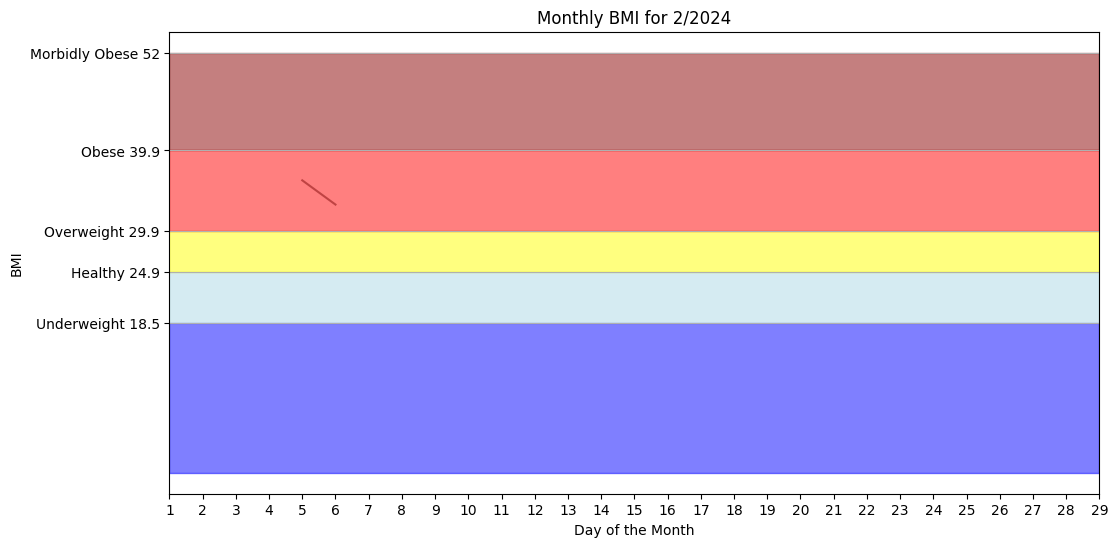

In [42]:
bmi.monthly_bmi_data(2, 2024)

In [43]:
# bmi.yearly_bmi_data(2023)

In [44]:
db.close_connection()


LocalDB Connection Closed
